<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-tool-calling-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_groq langchain tavily-python replicate langgraph matplotlib

# LangGraph Tool Calling Agent with Llama3

LLM-powered agents combine planning, memory, and tool-use (see [here](https://lilianweng.github.io/posts/2023-06-23-agent/), [here](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/)). 

LangGraph is a library that can be used to build agents:
 
1) It allows us to define `nodes` for our assistant (which decides whether to call a tool) and our actions (tool calls).
2) It allows us to define specific `edges` that connect these nodes (e.g., based upon whether a tool call is decided).
3) It enables `cycles`, where we can call our assistant in a loop until a stopping condition.

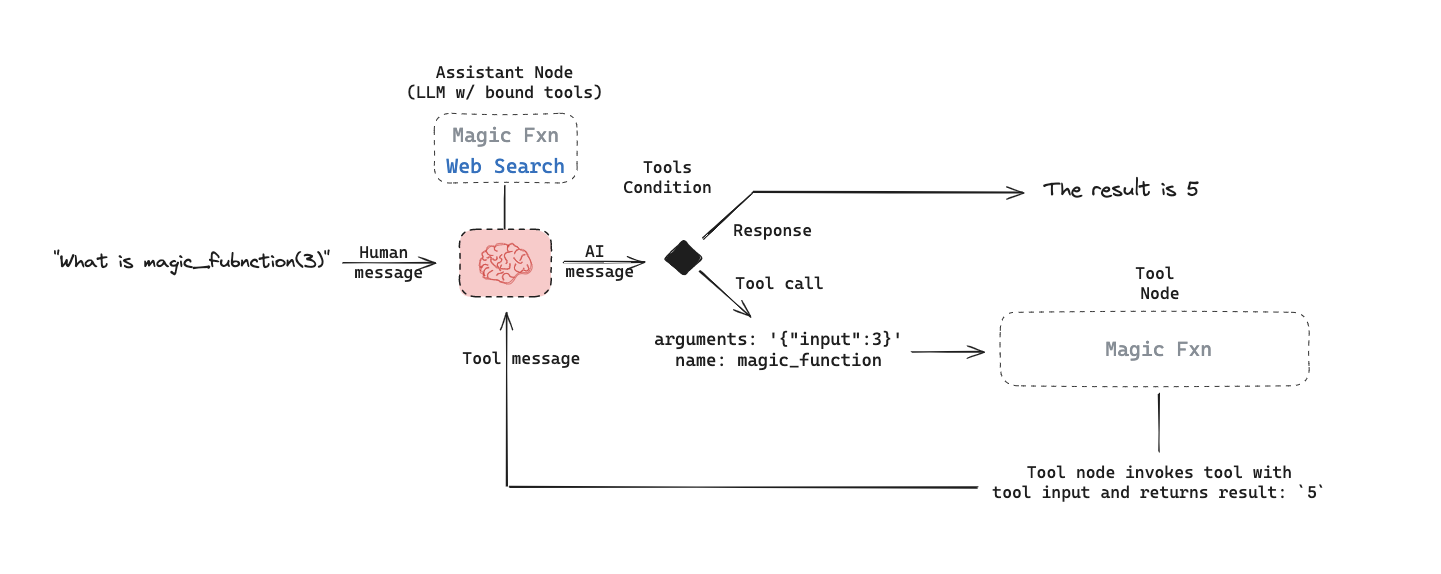

We'll augment a tool-calling version of Llama 3 with various multi-model capabilities using an agent. 

### Enviorment

We'll use [Tavily](https://tavily.com/#api) for web search.

We'll use [Replicate](https://replicate.com/), which offers free to try API key and for various multi-modal capabilities.

We can review LangChain LLM integrations that support tool calling [here](https://python.langchain.com/docs/integrations/chat/).

Groq is included. [Here](https://github.com/groq/groq-api-cookbook/blob/main/llama3-stock-market-function-calling/llama3-stock-market-function-calling.ipynb) is a notebook by Groq on function calling with Llama 3 and LangChain.

In [ ]:
import os
from getpass import getpass
TAVILY_API_KEY = getpass()
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [ ]:
REPLICATE_API_TOKEN = getpass()
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [ ]:
GROQ_API_KEY = getpass()
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

Optionally, add tracing:

In [ ]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

In [ ]:
import os
os.environ["LANGCHAIN_PROJECT"] = "llama3-tool-use-agent"

### Define tools

These are the same tools that we used in the [tool-calling-agent notebook](tool-calling-agent.ipynb).

In [ ]:
import replicate

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from langchain_community.tools.tavily_search import TavilySearchResults

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

@tool
def web_search(input: str) -> str:
    """Runs web search."""
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": input})
    return docs

@tool
def text2image(text: str) -> str:
    """generate an image based on a text."""
    output = replicate.run(
        "stability-ai/sdxl:7762fd07cf82c948538e41f63f77d685e02b063e37e496e96eefd46c929f9bdc",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, # a yellow lab puppy running free with wild flowers in the mountain behind
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]

@tool
def image2text(image_url: str, prompt: str) -> str:
    """generate text for image_url based on prompt."""
    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

@tool
def text2speech(text: str) -> int:
    """convert text to a speech."""
    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

# List of tools
tools = [
    magic_function,
    web_search,
    text2image,
    image2text,
    text2speech
]

### State

This list of messages is passed to each node of our agent.

This will serve as short-term memory that persists during the lifetime of our agent. 

See [this overview](https://github.com/langchain-ai/langgraph) of LangGraph for more detail.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Assistant 

This is Llama 3, with tool-calling, using [Groq](https://python.langchain.com/v0.1/docs/integrations/chat/groq/).

We bind the available tools to Llama 3. 

And we further specify the available tools in our assistant prompt.

In [ ]:
from datetime import datetime
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Get any user-provided configs 
            image_url = config['configurable'].get("image_url", None)
            # Append to state
            state = {**state, "image_url": image_url}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Prompt 
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for with five tools: (1) web search, "
            "(2) a custom, magic_function, (3) text to image, (4) image to text "
            "(5) text to speech. Use these provided tools in response to the user question. "
            "Your image url is: {image_url} "
            "Current time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# LLM chain
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Graph

Here, we lay out the graph.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

We can visualize it.

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Test

Now, we can test each tool!

See the traces to audit specifically what is happening.

In [ ]:
questions = ["What is magic_function(3)",
             "What is the weather in SF?",
             "Generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the mountain behind'",
             "Tell me a story about this image",
             "Convert this text to speech: The image features a small white dog running down a dirt path, surrounded by a beautiful landscape. The dog is happily smiling as it runs, and the path is lined with colorful flowers, creating a vibrant and lively atmosphere. The scene appears to be set in a mountainous area, adding to the picturesque nature of the image."
            ]

In [ ]:
import uuid 
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[0])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

Trace: 

https://smith.langchain.com/public/e4f4055f-eb68-482a-8843-cecc67ea76d3/r

In [ ]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[1])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

Trace: 

https://smith.langchain.com/public/1a46bdba-448b-4b23-a78b-650d28d5ee7f/r

In [ ]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[2])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

Trace: 

https://smith.langchain.com/public/cc9ca4f1-05c8-4dea-a85b-c852f22c14ae/r

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(image_url):
    """Display generated image"""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))  
    plt.imshow(img)
    plt.axis('off')
    plt.show()

image_url = event['messages'][-2].content
display_image(image_url)

In [ ]:
import uuid 

_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[3])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

Trace: 

https://smith.langchain.com/public/89f45ee4-effc-4cca-b3e6-f12cf5c29168/r

In [ ]:
_printed = set()
image_url = None
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "image_url": image_url,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[4])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

In [ ]:
from IPython.display import Audio

def play_audio(output_url):
    return Audio(url=output_url, autoplay=False)

audio_url = event['messages'][-2].content
play_audio(audio_url)

Trace: 

https://smith.langchain.com/public/b504a513-3123-4bfd-8796-3364968559b2/r